In [1]:
from tucan.io import graph_from_file
from tucan.canonicalization import partition_molecule_by_attribute, refine_partitions, get_refinement_tree_node_children, get_refinement_tree_levels
from tucan.visualization import draw_molecules
from tucan.graph_attributes import PARTITION, INVARIANT_CODE

In [2]:
m_name = "Petersen_graph"
m = graph_from_file(f"../tests/molfiles/{m_name}/{m_name}.mol")
m_partitioned_by_invariants = partition_molecule_by_attribute(m, INVARIANT_CODE)

At this point, all node attributes that are included in `INVARIANT_CODE` are encoded in the node's `PARTITION` attribute.
That is, in the subsequent canonicalization steps, all node attributes that are included in `INVARIANT_CODE` can be disregarded.

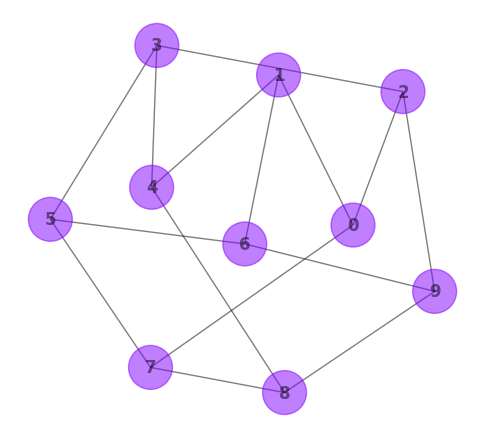

In [3]:
m_refined = list(refine_partitions(m_partitioned_by_invariants))[-1]
draw_molecules([m_refined], [""], highlight=PARTITION)

Build refinement tree with BFS.
See https://doi.org/10.1016/j.jsc.2013.09.003 and https://pallini.di.uniroma1.it/SearchTree.html.

Side note: Both atoms and vertices on the refinement tree are called "nodes" atm.
Call node on the refinement tree "refinement-tree-node" to avoid confusion.

Once the partitions are maximally refined, we need to artificially refine them until they're discrete.
In order to artificially refine the partitions, we need to split them. See `get_refinement_tree_node_children`.
Below we show how to generate the nodes for one level of the refinement tree.

10


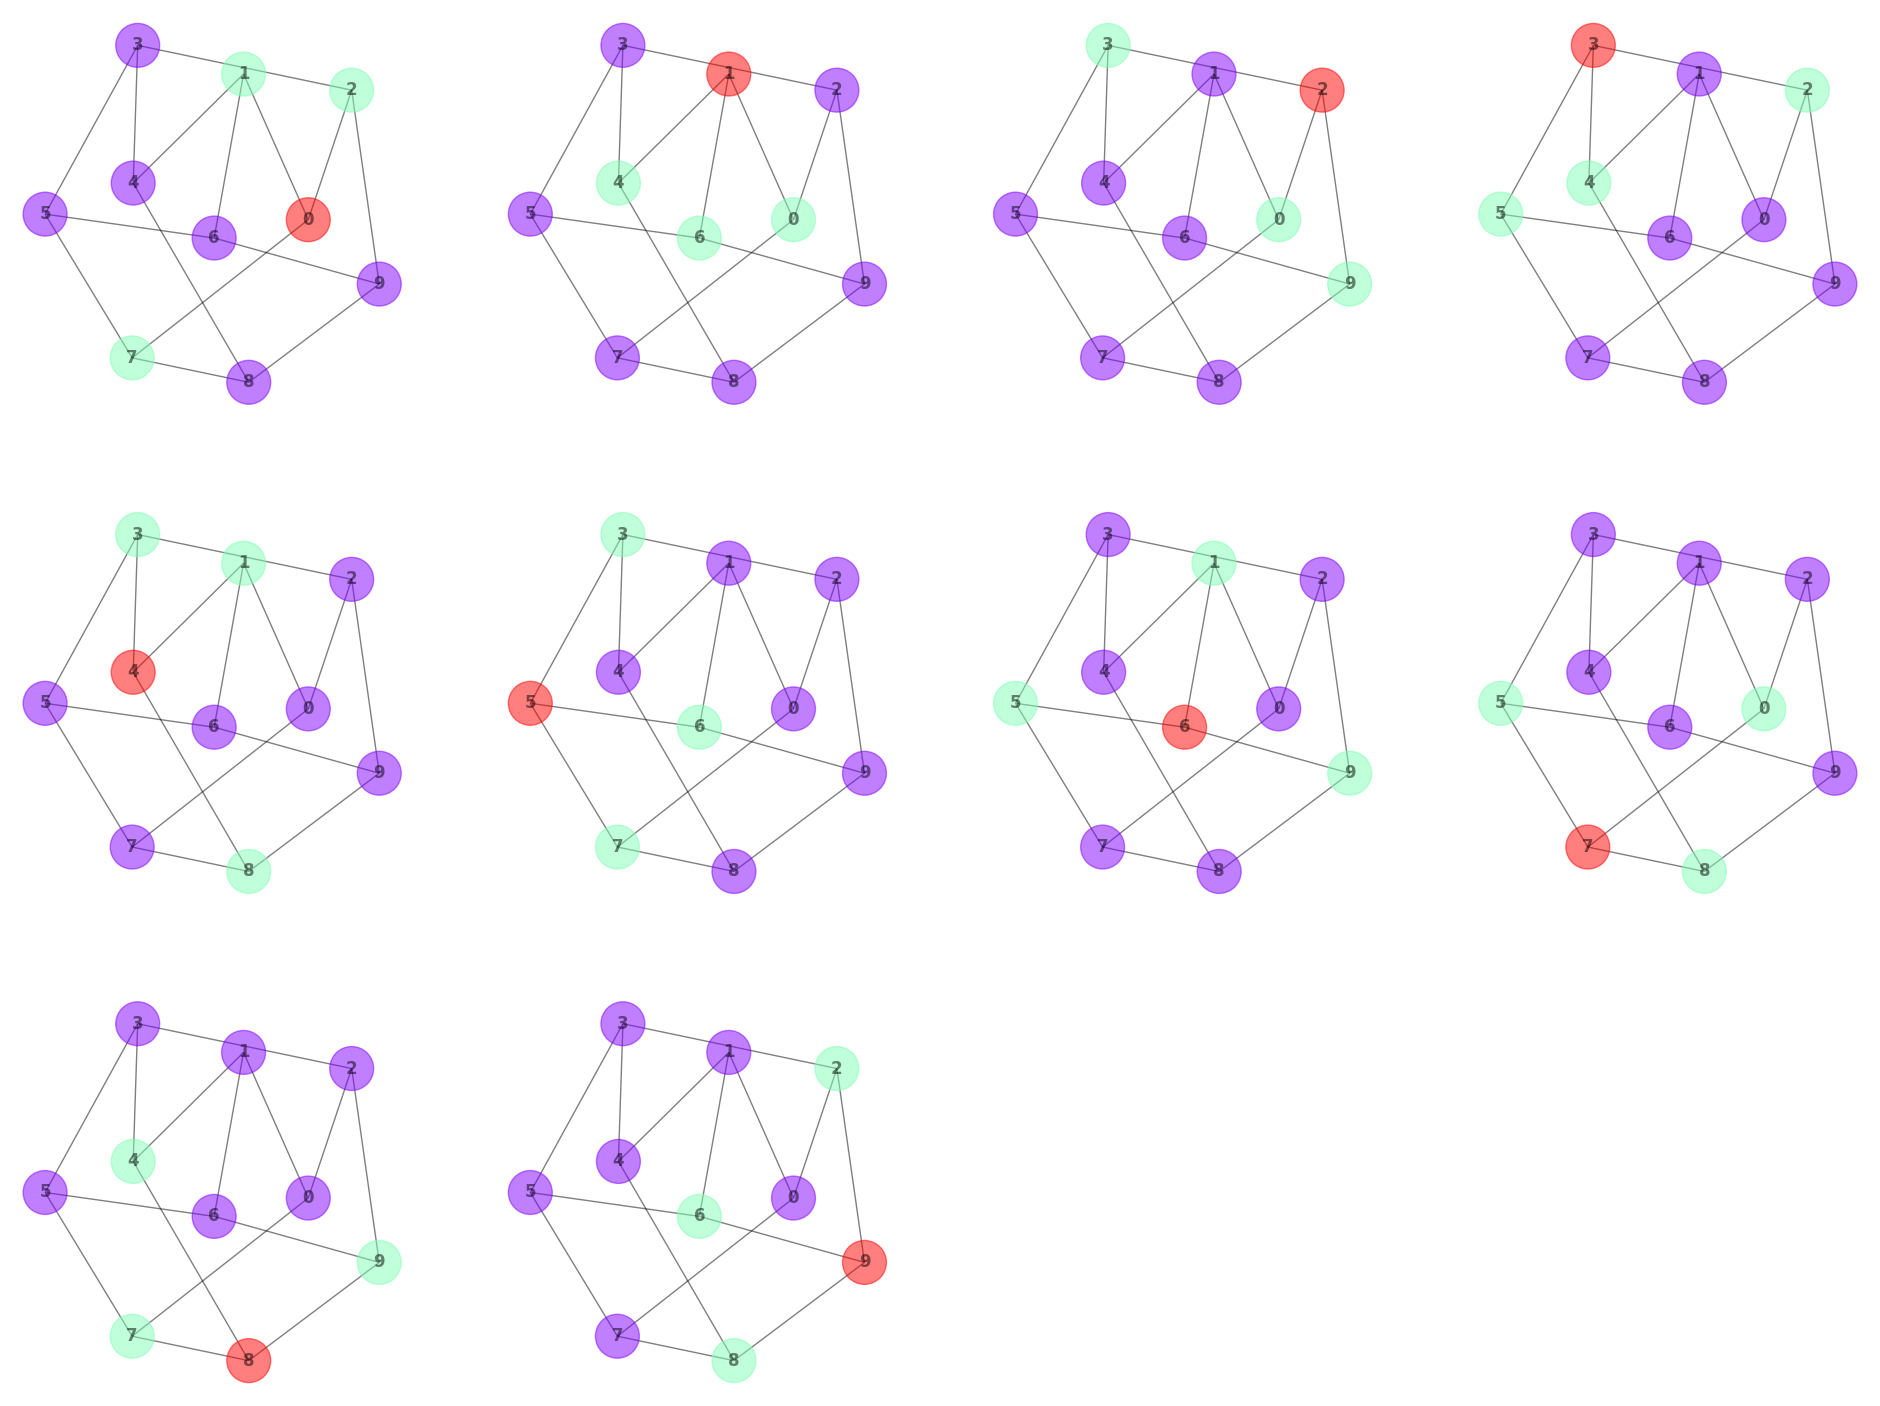

In [4]:
children = list(get_refinement_tree_node_children(m_refined))
print(len(children))
draw_molecules(children, ["" for _ in range(len(children))], highlight=PARTITION)

Let's build up the entire refinement-tree. The leaves (i.e., nodes at the final level) are the discrete partitionings.
Note: Distinguish between "partitioning" (set of partitions of one graph) and "partition".

The leaves of the refinement-tree are the 120 automorphisms of the [Petersen graph](https://en.wikipedia.org/wiki/Petersen_graph). Also see https://pallini.di.uniroma1.it/SearchTree.html.

4


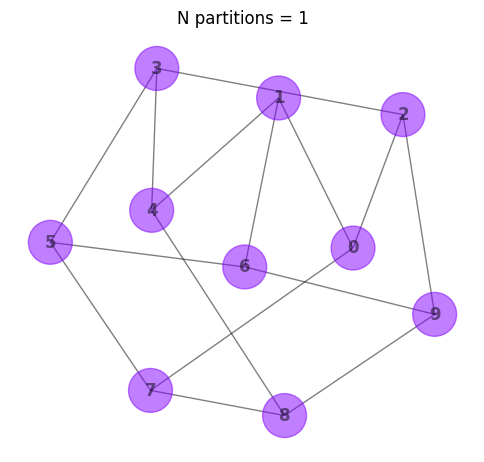

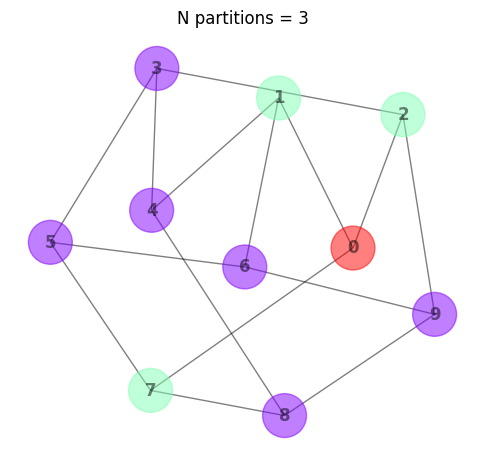

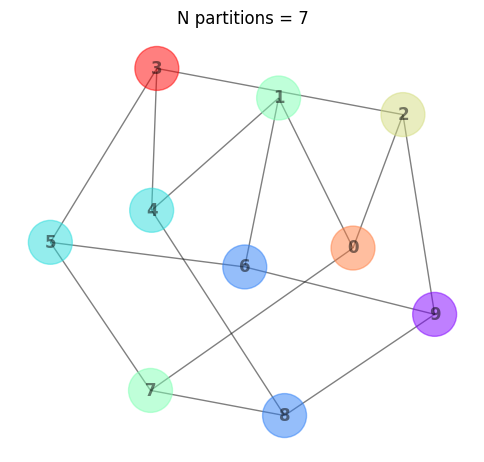

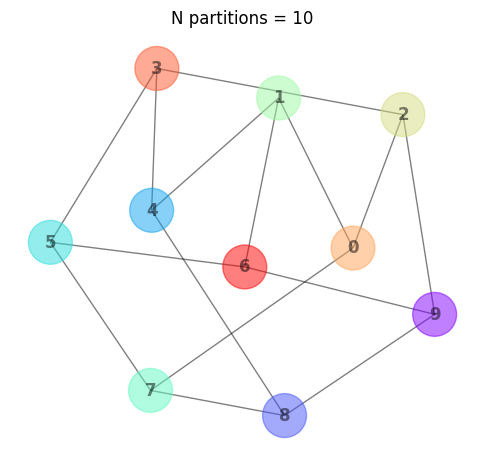

In [5]:
refinement_tree_levels = list(get_refinement_tree_levels(m_refined))
print(len(refinement_tree_levels))
for level in refinement_tree_levels:
    draw_molecules(level, [f"N partitions = {m.graph["n_partitions"]}" for m in level], highlight=PARTITION)

## Feedback on performance and correctness

Currently (HEAD commit on `main` at December 23 2025) `pytest tests/test_canonicalization.py::test_permutation_invariance` fails for 2 structures (exclusively timeout failures, no invariance failures):

```
==================================== short test summary info =====================================
FAILED tests/test_canonicalization.py::test_permutation_invariance[C240] - Failed: Timeout (>10.0s) from pytest-timeout.
FAILED tests/test_canonicalization.py::test_permutation_invariance[C36_H72_Cl4_N14_Zn2_0_5_CH3CN_2_5_Et2O_in_P-1] - Failed: Timeout (>10.0s) from pytest-timeout.
============================ 2 failed, 231 passed in 72.98s (0:01:12) ============================

```

The goal is to bring that number down by optimizing performance (e.g., additional pruning of refinement-tree, increasing efficiency of automorphism filter).

For faster feedback run `pytest tests/test_canonicalization.py::test_permutation_invariance[<failed ID>]`.

Note (December 19 2025): Bumping Python from 3.12 to 3.13 resulted in a significant speed up (~118s down to ~78s) and consequently reduced timeout failures from 3 to 2.